# Validating Chaotic Back-Propagation(CBP) on single-neuron model

## 1. example of training with BP

In [1]:
import torch
import torch.nn as nn

In [2]:
inp = torch.FloatTensor([[1]]) # input sample
tgt = torch.FloatTensor([[0]]) # target of input

In [3]:
# def single-neuron network
class SingleNet(nn.Module):
    def __init__(self, init_value=0):
        super().__init__()
        self.layer = nn.Linear(1, 1)
        self.act_func = nn.Sigmoid()
        nn.init.constant_(self.layer.weight, init_value)
        nn.init.constant_(self.layer.bias, init_value)
        
    def forward(self, x):
        out = self.act_func(self.layer(x))
        return out

In [4]:
loss_func = nn.MSELoss() # loss function

In [5]:
# training with BP
net = SingleNet()
optimizer = torch.optim.SGD(net.parameters(), lr=1)

loss_list = []
weight_list = []
bias_list = []
for i in range(1000):
    optimizer.zero_grad()
    out = net(inp)
    loss_bp = loss_func(out, tgt)
    loss_bp.backward()
    optimizer.step()
    loss_list.append(loss_bp.item())
    weight_list.append(net.layer.weight.item())
    bias_list.append(net.layer.bias.item())

In [6]:
# define the plot function
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

def plot_series(series, xlabel='epoch', ylabel=None, title=None, save_path=None, **kwargs):
    n_ele = len(series)
    fig, ax = plt.subplots()
    ax.scatter(range(n_ele), series, s=5, **kwargs)
    ax.set_xlabel(xlabel)
    if ylabel is not None: ax.set_ylabel(ylabel)
    if title is not None: ax.set_title(title)
    plt.tight_layout()
    if save_path is not None:
        fig.savefig(save_path, dpi=200)
    plt.show()
    
# def plot_series(series, xlabel='epoch', ylabel=None, title=None, save_path=None, 
#                 z=9, beta=0.999, show_z=False, **kwargs):
#     n_ele = len(series)
#     fig, ax = plt.subplots()
#     ax.scatter(range(n_ele), series, s=5, c='b', **kwargs)
#     ax.set_xlabel(xlabel)
    
#     if show_z:
#         ax2 = ax.twinx()
#         ax2.scatter(range(n_ele), [z * beta ** i for i in range(n_ele)], s=5, c='r')
#         ax2.set_ylabel('z', c='r')
#         ax2.tick_params(axis='y', colors='r')
#         ax2.grid(axis='y')
        
#     ax.tick_params(axis='y', colors='b')
#     if ylabel is not None: ax.set_ylabel(ylabel, c='b')
#     if title is not None: ax.set_title(title)
#     plt.tight_layout()
#     if save_path is not None:
#         fig.savefig(save_path, dpi=200)
#     plt.show()

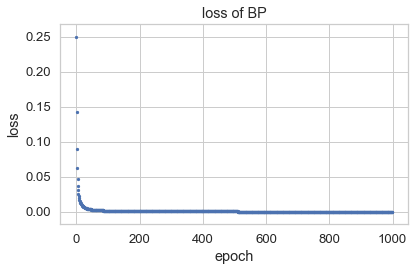

In [7]:
plot_series(loss_list, ylabel='loss', title='loss of BP')

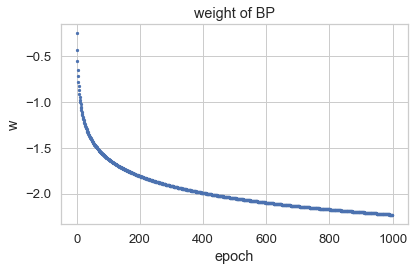

In [8]:
plot_series(weight_list, ylabel='w', title='weight of BP')

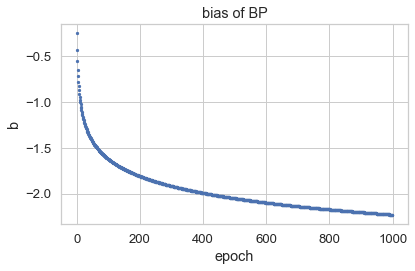

In [9]:
plot_series(bias_list, ylabel='b', title='bias of BP')

## 2. example of training with CBP

In [10]:
# define the chaotic loss function
def chaos_loss(out, z, I0=0.65):
    return -z * (I0 * torch.log(out) + (1 - I0) * torch.log(1 - out))

In [11]:
# training with CBP
net = SingleNet()
optimizer = torch.optim.SGD(net.parameters(), lr=1)

beta = 0.999
z = 9

loss_bp_list = []
loss_cbp_list = []
weight_list = []
bias_list = []
for i in range(1000):
    optimizer.zero_grad()
    out = net(inp)
    loss_bp = loss_func(out, tgt)
    loss_chaos = chaos_loss(out, z) # chaotic loss
    loss_cbp = loss_bp + loss_chaos # loss of CBP
    loss_cbp.backward()
    optimizer.step()
    z *= beta
    
    loss_bp_list.append(loss_bp.item())
    loss_cbp_list.append(loss_cbp.item())
    weight_list.append(net.layer.weight.item())
    bias_list.append(net.layer.bias.item())

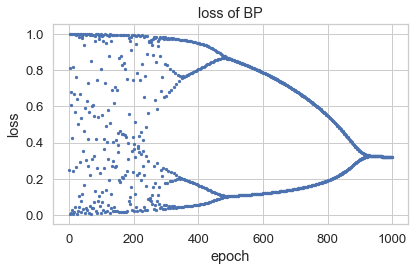

In [12]:
# origin loss of BP
plot_series(loss_bp_list, ylabel='loss', title='loss of BP')

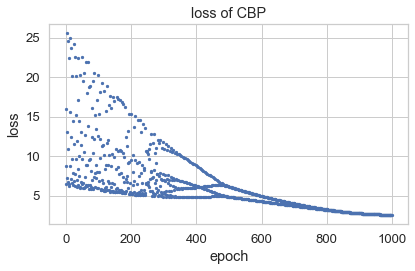

In [13]:
# loss of CBP (loss_cbp = loss_bp + loss_chaos)
plot_series(loss_cbp_list, ylabel='loss', title='loss of CBP')

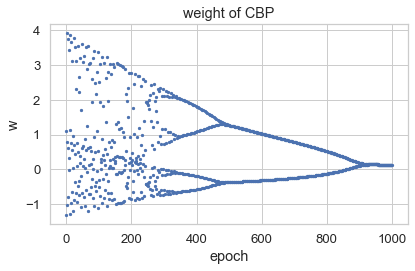

In [14]:
plot_series(weight_list, ylabel='w', title='weight of CBP')

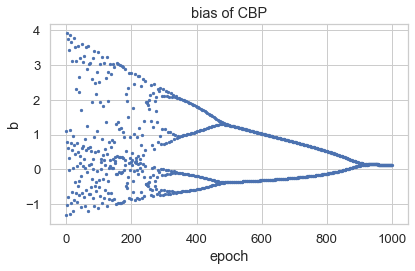

In [15]:
plot_series(bias_list, ylabel='b', title='bias of CBP')

## 3. example of training with CBP (in form of optimizer)

In [16]:
from cbpy import chaos_optim, MLPS

In [17]:
net = MLPS([1, 1], active_last=True, act_layer=nn.Sigmoid(),init_mode=0)
net(inp, return_hid=True) # in addition to final output, also return the hidden output for the optimizer

([tensor([[0.5000]]), tensor([0.5000])],
 tensor([[0.5000]], grad_fn=<SigmoidBackward>))

In [18]:
import numpy as np

optimizer = chaos_optim.SGD(net.parameters(), lr=1) # require hidden output to update the weight

beta = 0.999
z = np.array([9., 9.])

loss_bp_list = []
weight_list = []
bias_list = []
for i in range(1000):
    optimizer.zero_grad()
    hid, out = net(inp, return_hid=True) # the first difference from BP
    loss_bp = loss_func(out, tgt)
    loss_bp.backward()
    optimizer.step(z, hid) # the second difference from BP
    z *= beta
    
    loss_bp_list.append(loss_bp.item())
    weight_list.append(net.model[0].weight.item())
    bias_list.append(net.model[0].bias.item())

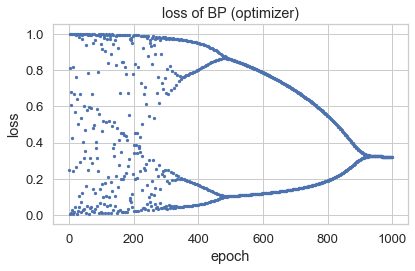

In [19]:
plot_series(loss_bp_list, ylabel='loss', title='loss of BP (optimizer)')

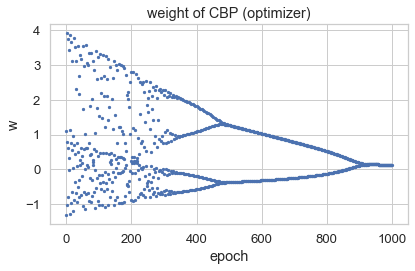

In [20]:
plot_series(weight_list, ylabel='w', title='weight of CBP (optimizer)')

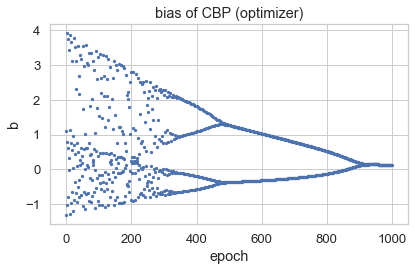

In [21]:
plot_series(bias_list, ylabel='b', title='bias of CBP (optimizer)')

## 4. example of training with CBP (using cbp.train API in practice)

In [22]:
import cbpy as cbp

In [23]:
from torch.utils.data import DataLoader, TensorDataset

# define the trainloader
trainloader = DataLoader(TensorDataset(inp, tgt), 1)
next(iter(trainloader))

[tensor([[1.]]), tensor([[0.]])]

In [24]:
net = cbp.MLPS([1, 1], active_last=True, act_layer=nn.Sigmoid(), init_mode=0)

In [25]:
# training api in cbp
loss_list, acc_list, weight_list, out_list = cbp.train_with_chaos(
    model=net, trainloader=trainloader, testloader=trainloader, loss_func=loss_func,
    zs=9, cbp_epoch=1000, cbp_lr=1, record_weight=True, whole_weight=True, beta=0.999)

--------------------------------------------------
Train Params:
  zs: 9
  beta: 0.999
  cbp_epoch: 1000
  max_epoch: 1000
  cbp_lr: 1
  bp_lr: 1
  bp_momentum: 0
  bp_adam: False
  logfile: ./results/train.log
--------------------------------------------------
==================== start training ====================
EPOCH:     1 | CBP | train loss: 0.2500 | test acc: 0.0000
EPOCH:     2 | CBP | train loss: 0.8104 | test acc: 1.0000
EPOCH:     3 | CBP | train loss: 0.0046 | test acc: 0.0000
EPOCH:     4 | CBP | train loss: 0.9992 | test acc: 0.0000
EPOCH:     5 | CBP | train loss: 0.6794 | test acc: 1.0000
EPOCH:     6 | CBP | train loss: 0.0129 | test acc: 0.0000
EPOCH:     7 | CBP | train loss: 0.9989 | test acc: 0.0000
EPOCH:     8 | CBP | train loss: 0.6052 | test acc: 1.0000
EPOCH:     9 | CBP | train loss: 0.0296 | test acc: 0.0000
EPOCH:    10 | CBP | train loss: 0.9979 | test acc: 0.0000
EPOCH:    11 | CBP | train loss: 0.4272 | test acc: 1.0000
EPOCH:    12 | CBP | train loss:

EPOCH:   135 | CBP | train loss: 0.9458 | test acc: 1.0000
EPOCH:   136 | CBP | train loss: 0.0275 | test acc: 0.0000
EPOCH:   137 | CBP | train loss: 0.9946 | test acc: 0.0000
EPOCH:   138 | CBP | train loss: 0.3696 | test acc: 0.0000
EPOCH:   139 | CBP | train loss: 0.3929 | test acc: 0.0000
EPOCH:   140 | CBP | train loss: 0.3286 | test acc: 0.0000
EPOCH:   141 | CBP | train loss: 0.5160 | test acc: 1.0000
EPOCH:   142 | CBP | train loss: 0.1080 | test acc: 0.0000
EPOCH:   143 | CBP | train loss: 0.9650 | test acc: 1.0000
EPOCH:   144 | CBP | train loss: 0.0505 | test acc: 0.0000
EPOCH:   145 | CBP | train loss: 0.9895 | test acc: 1.0000
EPOCH:   146 | CBP | train loss: 0.2131 | test acc: 0.0000
EPOCH:   147 | CBP | train loss: 0.8290 | test acc: 1.0000
EPOCH:   148 | CBP | train loss: 0.0135 | test acc: 0.0000
EPOCH:   149 | CBP | train loss: 0.9960 | test acc: 0.0000
EPOCH:   150 | CBP | train loss: 0.4783 | test acc: 1.0000
EPOCH:   151 | CBP | train loss: 0.1558 | test acc: 0.00

EPOCH:   274 | CBP | train loss: 0.9791 | test acc: 1.0000
EPOCH:   275 | CBP | train loss: 0.2153 | test acc: 0.0000
EPOCH:   276 | CBP | train loss: 0.7643 | test acc: 1.0000
EPOCH:   277 | CBP | train loss: 0.0327 | test acc: 0.0000
EPOCH:   278 | CBP | train loss: 0.9836 | test acc: 0.0000
EPOCH:   279 | CBP | train loss: 0.2742 | test acc: 0.0000
EPOCH:   280 | CBP | train loss: 0.6160 | test acc: 1.0000
EPOCH:   281 | CBP | train loss: 0.0650 | test acc: 0.0000
EPOCH:   282 | CBP | train loss: 0.9679 | test acc: 1.0000
EPOCH:   283 | CBP | train loss: 0.1440 | test acc: 0.0000
EPOCH:   284 | CBP | train loss: 0.8910 | test acc: 1.0000
EPOCH:   285 | CBP | train loss: 0.0415 | test acc: 0.0000
EPOCH:   286 | CBP | train loss: 0.9792 | test acc: 1.0000
EPOCH:   287 | CBP | train loss: 0.2289 | test acc: 0.0000
EPOCH:   288 | CBP | train loss: 0.7271 | test acc: 1.0000
EPOCH:   289 | CBP | train loss: 0.0385 | test acc: 0.0000
EPOCH:   290 | CBP | train loss: 0.9800 | test acc: 1.00

EPOCH:   413 | CBP | train loss: 0.0619 | test acc: 0.0000
EPOCH:   414 | CBP | train loss: 0.9417 | test acc: 1.0000
EPOCH:   415 | CBP | train loss: 0.1542 | test acc: 0.0000
EPOCH:   416 | CBP | train loss: 0.8184 | test acc: 1.0000
EPOCH:   417 | CBP | train loss: 0.0635 | test acc: 0.0000
EPOCH:   418 | CBP | train loss: 0.9393 | test acc: 1.0000
EPOCH:   419 | CBP | train loss: 0.1509 | test acc: 0.0000
EPOCH:   420 | CBP | train loss: 0.8223 | test acc: 1.0000
EPOCH:   421 | CBP | train loss: 0.0651 | test acc: 0.0000
EPOCH:   422 | CBP | train loss: 0.9366 | test acc: 1.0000
EPOCH:   423 | CBP | train loss: 0.1476 | test acc: 0.0000
EPOCH:   424 | CBP | train loss: 0.8262 | test acc: 1.0000
EPOCH:   425 | CBP | train loss: 0.0669 | test acc: 0.0000
EPOCH:   426 | CBP | train loss: 0.9338 | test acc: 1.0000
EPOCH:   427 | CBP | train loss: 0.1442 | test acc: 0.0000
EPOCH:   428 | CBP | train loss: 0.8302 | test acc: 1.0000
EPOCH:   429 | CBP | train loss: 0.0688 | test acc: 0.00

EPOCH:   552 | CBP | train loss: 0.8251 | test acc: 1.0000
EPOCH:   553 | CBP | train loss: 0.1118 | test acc: 0.0000
EPOCH:   554 | CBP | train loss: 0.8236 | test acc: 1.0000
EPOCH:   555 | CBP | train loss: 0.1121 | test acc: 0.0000
EPOCH:   556 | CBP | train loss: 0.8222 | test acc: 1.0000
EPOCH:   557 | CBP | train loss: 0.1124 | test acc: 0.0000
EPOCH:   558 | CBP | train loss: 0.8207 | test acc: 1.0000
EPOCH:   559 | CBP | train loss: 0.1127 | test acc: 0.0000
EPOCH:   560 | CBP | train loss: 0.8192 | test acc: 1.0000
EPOCH:   561 | CBP | train loss: 0.1130 | test acc: 0.0000
EPOCH:   562 | CBP | train loss: 0.8177 | test acc: 1.0000
EPOCH:   563 | CBP | train loss: 0.1133 | test acc: 0.0000
EPOCH:   564 | CBP | train loss: 0.8162 | test acc: 1.0000
EPOCH:   565 | CBP | train loss: 0.1136 | test acc: 0.0000
EPOCH:   566 | CBP | train loss: 0.8147 | test acc: 1.0000
EPOCH:   567 | CBP | train loss: 0.1139 | test acc: 0.0000
EPOCH:   568 | CBP | train loss: 0.8131 | test acc: 1.00

EPOCH:   691 | CBP | train loss: 0.1408 | test acc: 0.0000
EPOCH:   692 | CBP | train loss: 0.6965 | test acc: 1.0000
EPOCH:   693 | CBP | train loss: 0.1414 | test acc: 0.0000
EPOCH:   694 | CBP | train loss: 0.6943 | test acc: 1.0000
EPOCH:   695 | CBP | train loss: 0.1420 | test acc: 0.0000
EPOCH:   696 | CBP | train loss: 0.6920 | test acc: 1.0000
EPOCH:   697 | CBP | train loss: 0.1426 | test acc: 0.0000
EPOCH:   698 | CBP | train loss: 0.6897 | test acc: 1.0000
EPOCH:   699 | CBP | train loss: 0.1432 | test acc: 0.0000
EPOCH:   700 | CBP | train loss: 0.6874 | test acc: 1.0000
EPOCH:   701 | CBP | train loss: 0.1439 | test acc: 0.0000
EPOCH:   702 | CBP | train loss: 0.6850 | test acc: 1.0000
EPOCH:   703 | CBP | train loss: 0.1445 | test acc: 0.0000
EPOCH:   704 | CBP | train loss: 0.6827 | test acc: 1.0000
EPOCH:   705 | CBP | train loss: 0.1452 | test acc: 0.0000
EPOCH:   706 | CBP | train loss: 0.6803 | test acc: 1.0000
EPOCH:   707 | CBP | train loss: 0.1458 | test acc: 0.00

EPOCH:   830 | CBP | train loss: 0.4959 | test acc: 1.0000
EPOCH:   831 | CBP | train loss: 0.2151 | test acc: 0.0000
EPOCH:   832 | CBP | train loss: 0.4921 | test acc: 1.0000
EPOCH:   833 | CBP | train loss: 0.2170 | test acc: 0.0000
EPOCH:   834 | CBP | train loss: 0.4883 | test acc: 1.0000
EPOCH:   835 | CBP | train loss: 0.2190 | test acc: 0.0000
EPOCH:   836 | CBP | train loss: 0.4844 | test acc: 1.0000
EPOCH:   837 | CBP | train loss: 0.2210 | test acc: 0.0000
EPOCH:   838 | CBP | train loss: 0.4804 | test acc: 1.0000
EPOCH:   839 | CBP | train loss: 0.2231 | test acc: 0.0000
EPOCH:   840 | CBP | train loss: 0.4765 | test acc: 1.0000
EPOCH:   841 | CBP | train loss: 0.2252 | test acc: 0.0000
EPOCH:   842 | CBP | train loss: 0.4724 | test acc: 1.0000
EPOCH:   843 | CBP | train loss: 0.2273 | test acc: 0.0000
EPOCH:   844 | CBP | train loss: 0.4684 | test acc: 1.0000
EPOCH:   845 | CBP | train loss: 0.2295 | test acc: 0.0000
EPOCH:   846 | CBP | train loss: 0.4643 | test acc: 1.00

EPOCH:   969 | CBP | train loss: 0.3231 | test acc: 0.0000
EPOCH:   970 | CBP | train loss: 0.3230 | test acc: 0.0000
EPOCH:   971 | CBP | train loss: 0.3229 | test acc: 0.0000
EPOCH:   972 | CBP | train loss: 0.3229 | test acc: 0.0000
EPOCH:   973 | CBP | train loss: 0.3228 | test acc: 0.0000
EPOCH:   974 | CBP | train loss: 0.3227 | test acc: 0.0000
EPOCH:   975 | CBP | train loss: 0.3226 | test acc: 0.0000
EPOCH:   976 | CBP | train loss: 0.3225 | test acc: 0.0000
EPOCH:   977 | CBP | train loss: 0.3224 | test acc: 0.0000
EPOCH:   978 | CBP | train loss: 0.3223 | test acc: 0.0000
EPOCH:   979 | CBP | train loss: 0.3223 | test acc: 0.0000
EPOCH:   980 | CBP | train loss: 0.3222 | test acc: 0.0000
EPOCH:   981 | CBP | train loss: 0.3221 | test acc: 0.0000
EPOCH:   982 | CBP | train loss: 0.3220 | test acc: 0.0000
EPOCH:   983 | CBP | train loss: 0.3219 | test acc: 0.0000
EPOCH:   984 | CBP | train loss: 0.3218 | test acc: 0.0000
EPOCH:   985 | CBP | train loss: 0.3217 | test acc: 0.00

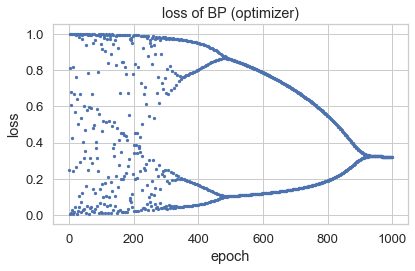

In [26]:
plot_series(loss_list, ylabel='loss', title='loss of BP (optimizer)')

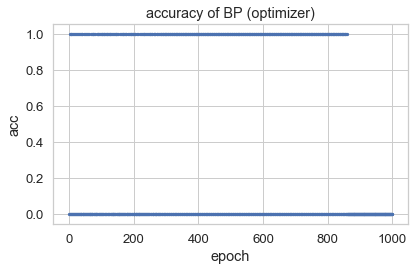

In [27]:
plot_series(acc_list, ylabel='acc', title='accuracy of BP (optimizer)')

In [28]:
w_list = [w[0].item() for w in weight_list]
b_list = [w[1].item() for w in weight_list]

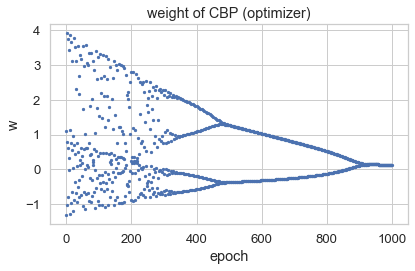

In [29]:
plot_series(w_list, ylabel='w', title='weight of CBP (optimizer)')

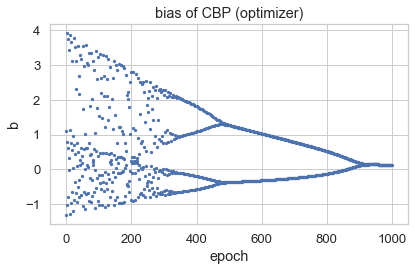

In [30]:
plot_series(b_list, ylabel='b', title='bias of CBP (optimizer)')